# Deep Hedging AI
### Vanilla Deep Hedging engine reference implementation with dynamic training update.
### This is the main example notebook

Hans Buehler, June 30 2022


In [1]:
"""
Slighly annoying: by default the SageMaker Python import directory does not include our git directory
"""
import os
p = os.getcwd()
end = "/deephedging/notebooks"
if p[-len(end):] == end:
    p = p[:-len(end)]
    import sys
    sys.path.append(p)
    print("SageMaker: added python path %s" % p)

SageMaker: added python path /home/ec2-user/SageMaker


Deep Hedging AI says hello  ... 

2023-01-08 10:52:01.424931: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-08 10:52:01.424989: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-57-75.us-east-2.compute.internal): /proc/driver/nvidia/version does not exist


Tensorflow version 2.7.1 running on 1 CPUs and 0 GPUs


## Deep Hedging in a Black \& Scholes World

2023-01-08 10:52:01.992791: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 10:52:03.011725: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Caching enabled @ '/home/ec2-user/dh_cache/525a190095ec9decf339c9045024ab3d.pck'
Cache successfully loaded. Current epoch: 399
Nothing to do: cached model loaded from /home/ec2-user/dh_cache/525a190095ec9decf339c9045024ab3d.pck represents a trained model up to 400 epochs (you have asked to train for 400 epochs).
Raise number of epochs or turn off caching to re-start training.

Plotting results for the trained model.

                                                                                                                                                                                                         


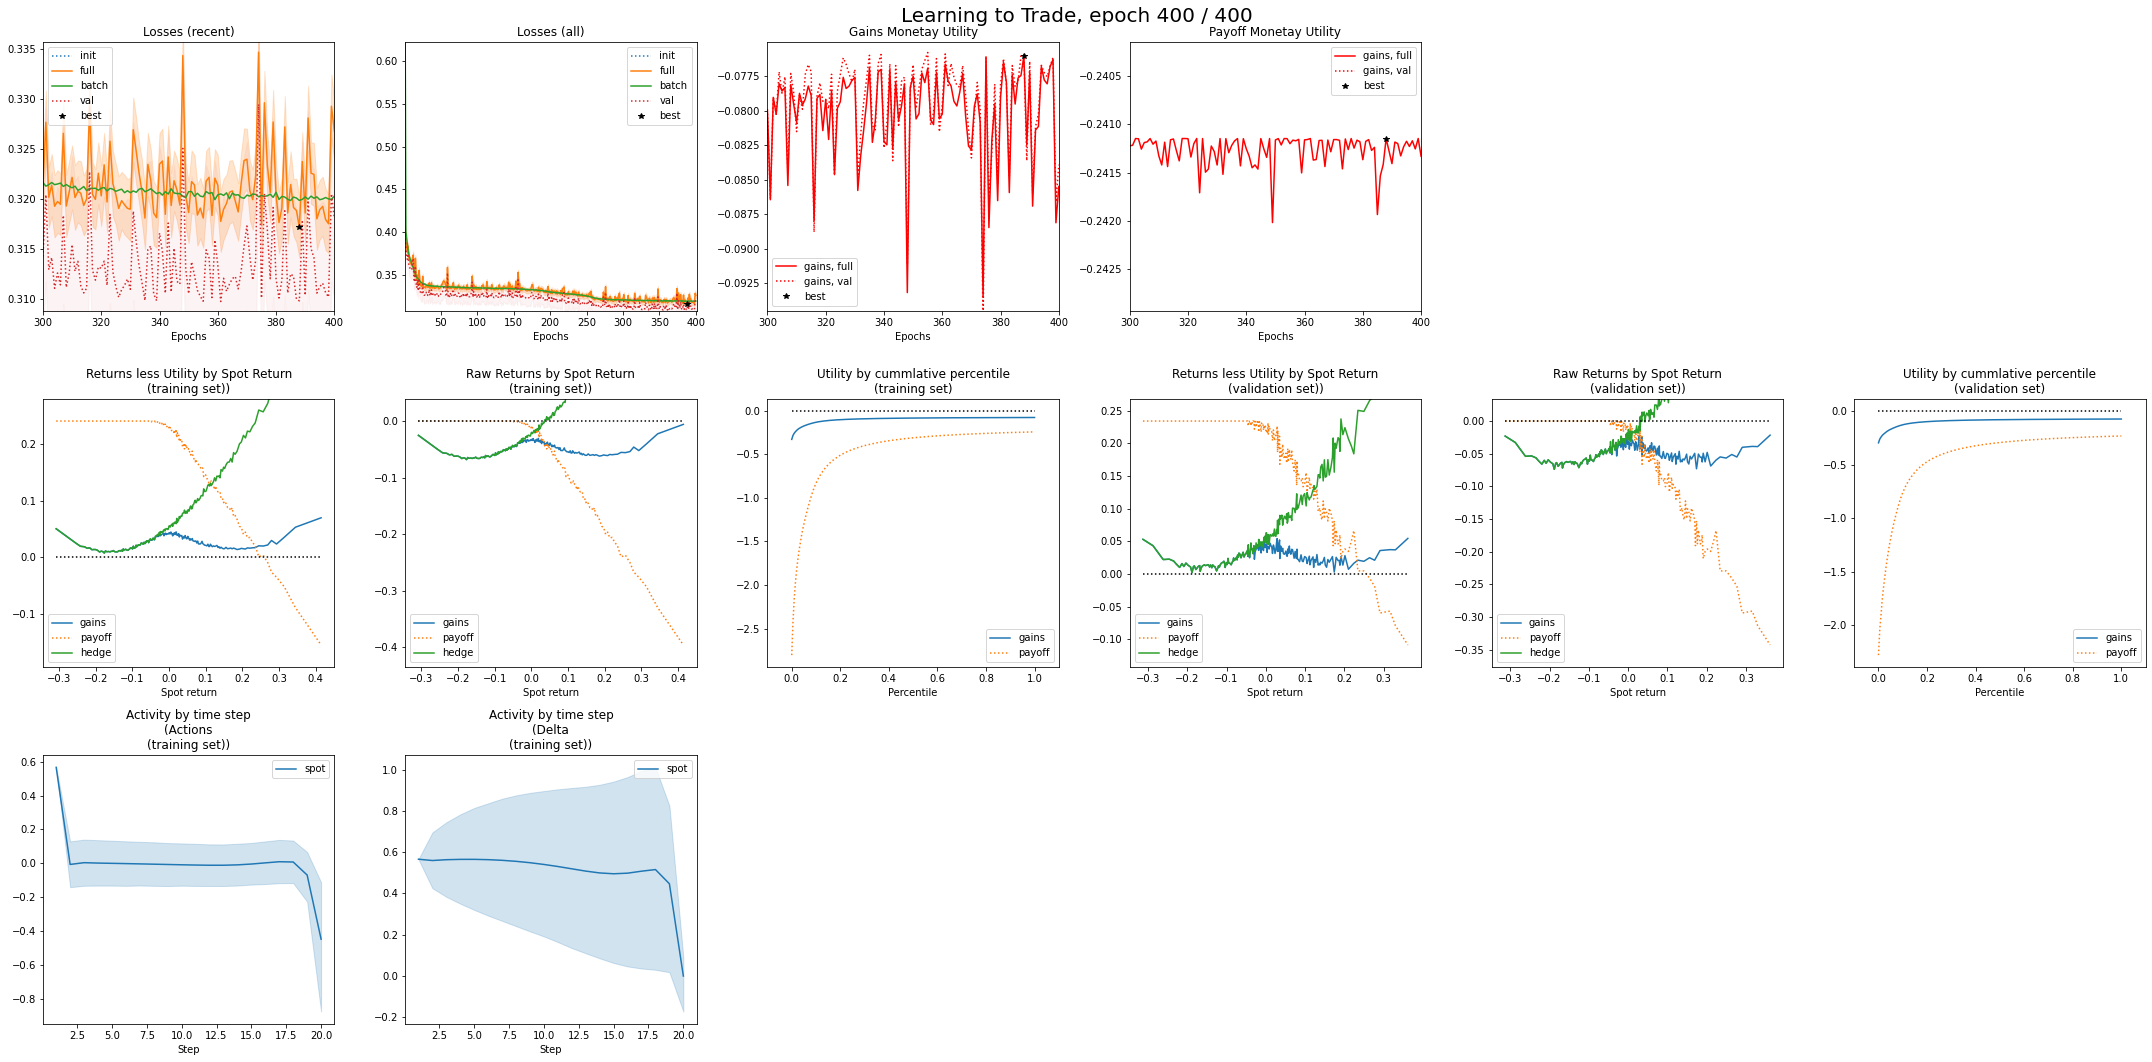

ZeroDivisionError: float division by zero

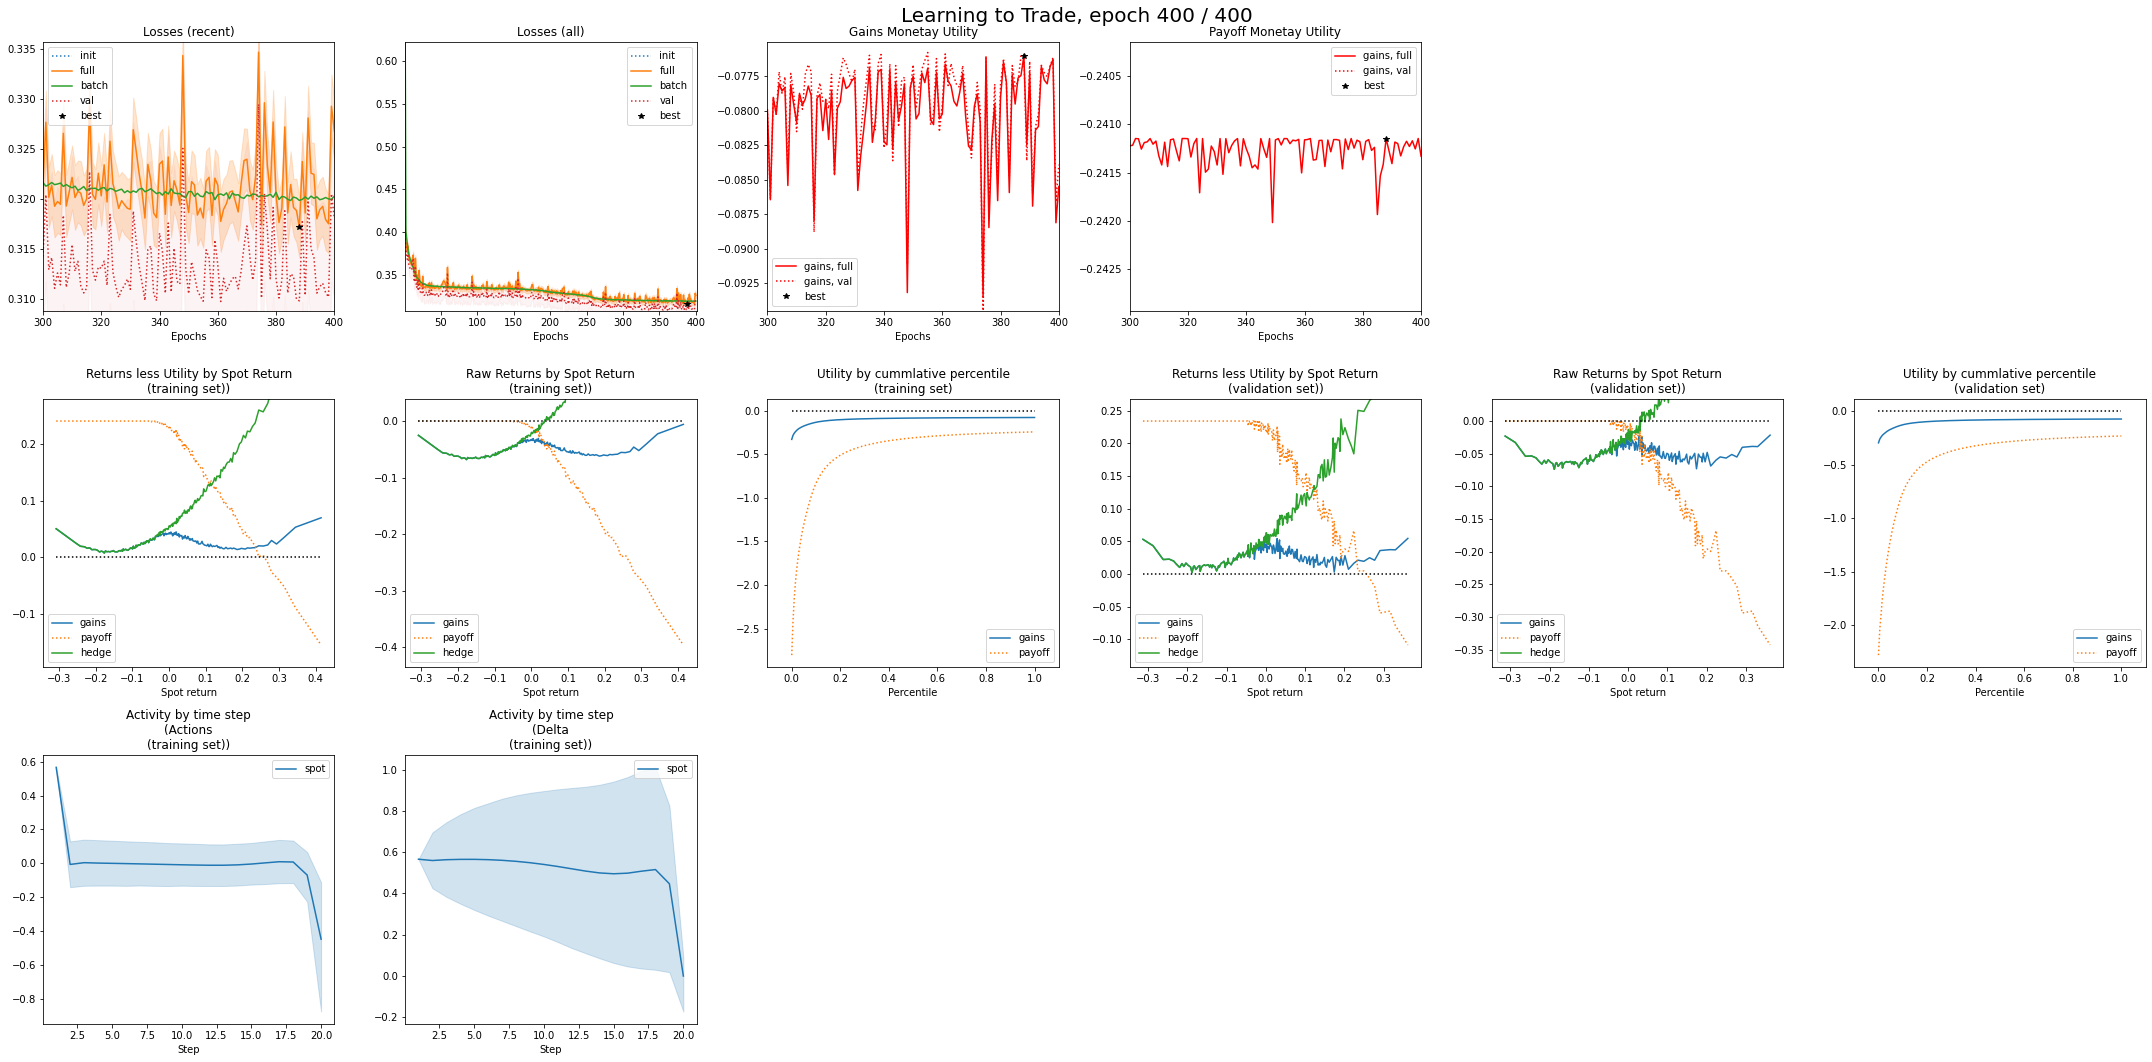

In [2]:
print("Deep Hedging AI says hello  ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = True
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 10.
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"
# trainer
config.trainer.train.batch_size = None
config.trainer.train.epochs = 400
config.trainer.visual.epoch_refresh = 1
config.trainer.visual.time_refresh = 10
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in a Black \& Scholes World"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=1000)

# create training environment
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()

### Comparison to Black & Scholes
Note that we use medium risk aversion, hence the hedge is not expected to match the risk-neutral hedge. See the sub directory <tt>blackscholes</tt> for experiments approximating the black & scholes solution

In [ ]:
import deephedging.plot_bs_hedge as plot_bs_hedge
import imp
imp.reload(plot_bs_hedge)

plot_bs_hedge.plot_blackscholes( world, gym, config )

In [ ]:
print("Deep Hedging AI says hello  ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM
import tensorflow as tf

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = False
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 10.
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"
# trainer
config.trainer.train.batch_size = None
config.trainer.train.epochs = 600
config.trainer.train.run_eagerly = None
config.trainer.visual.epoch_refresh = 1
config.trainer.visual.time_refresh = 10
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in simple Stochastic Volatility World"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=1000)

# create training environment
tf.debugging.enable_check_numerics()
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()